In [10]:
source("_targets.R")
library(cowplot)
library(ggplot2)
library(ggrastr)
library(reshape2)
library(scales)
library(Seurat)
library(targets)
library(tibble)

In [2]:
tar_load(indrop)

In [18]:
print(cor(FetchData(indrop, c("pros", str_glue("SPARSE_{1:15}"))))[, 1])

       pros    SPARSE_1    SPARSE_2    SPARSE_3    SPARSE_4    SPARSE_5 
 1.00000000 -0.21978934 -0.05263971 -0.19156673 -0.10269858 -0.05348658 
   SPARSE_6    SPARSE_7    SPARSE_8    SPARSE_9   SPARSE_10   SPARSE_11 
-0.03845548 -0.07454326 -0.11261240 -0.04738690 -0.01038912 -0.02411639 
  SPARSE_12   SPARSE_13   SPARSE_14   SPARSE_15 
-0.10330506  0.51167130 -0.04991882 -0.04759968 


In [19]:
print(indrop[["spca"]]@feature.loadings[, 13] %>% subset(. != 0))

  CG14989 Orcokinin      AstC     CCHa1     Npc2b unc-13-4A      IA-2      amon 
0.3268359 0.3339980 0.3720794 0.3291503 0.3095609 0.4147337 0.3615544 0.3691709 


In [2]:
tar_load(c(indrop.glm, tenx.glm))

In [3]:
colnames(indrop.glm$pca$Beta)

[1] "Intercept"            "clusterEB"            "clusterEC.anterior1" 
 [4] "clusterEC-like"       "clusterEC-like2"      "clusterEE.Ast"       
 [7] "clusterdEC1"          "clusterEC.anterior2"  "clusterEC.anterior3" 
[10] "clusterEC.anterior4"  "clustercopper/iron"   "clusterdEC2"         
[13] "clusterEC.meso"       "clusterLFC1"          "clusterothers.1"     
[16] "clusterEC.posterior1" "clusterEC.posterior2" "clusterEC.posterior3"
[19] "clustercardia1"       "clusterLFC2"          "clusterEC-like3"     
[22] "clusterEC.posterior4" "clusterothers.2"      "clustercardia2"      
[25] "clusterEC.posterior5" "clusterEC.anterior5"

In [4]:
design <- tibble(
  rowname = c("SPCA", "PCA"),
  data = list(indrop.glm$spca$Beta, tenx.glm$pca$Beta),
  design = sapply(
    data,
    \(Beta) cbind(
      ISC = 0,
      EB = colnames(Beta) == "clusterEB",
      dEC = grepl("dEC", colnames(Beta)),
      aEC = grepl("EC.ant", colnames(Beta)),
      "EC-like" = grepl("EC-like", colnames(Beta)),
      mEC = grepl("EC.meso", colnames(Beta)),
      pEC = grepl("EC.post", colnames(Beta)),
      EE = grepl("clusterEE", colnames(Beta)),
      "copper/iron" = grepl("copper", colnames(Beta)),
      LFC = grepl("LFC", colnames(Beta)),
      cardia = grepl("cardia", colnames(Beta))
    ) %>%
      `/`(
        matrix(pmax(1, colSums(.)), nrow = nrow(.), ncol = ncol(.), byrow = TRUE)
      ) %>%
      `+`(colnames(Beta) == "Intercept"),
    simplify=FALSE
  ),
  predictions = mapply(
    \(data, design) exp(data %*% design),
    data,
    design,
    SIMPLIFY=FALSE
  ),
  z = sapply(predictions, \(M) t(scale(t(M))), simplify=F),
)
round(design$design[[1]], 2)

ISC,EB,dEC,aEC,EC-like,mEC,pEC,EE,copper/iron,LFC,cardia
1,1,1.0,1.00,1.00,1,1.00,1.0,1,1.0,1
0,1,0.0,0.00,0.00,0,0.00,0.0,0,0.0,0
0,0,0.0,0.00,0.33,0,0.00,0.0,0,0.0,0
0,0,0.0,0.25,0.00,0,0.00,0.0,0,0.0,0
0,0,0.0,0.25,0.00,0,0.00,0.0,0,0.0,0
0,0,0.0,0.00,0.00,0,0.33,0.0,0,0.0,0
0,0,0.0,0.00,0.00,0,0.00,0.0,0,0.5,0
0,0,0.0,0.00,0.00,0,0.00,0.0,1,0.0,0
0,0,0.0,0.00,0.00,0,0.00,0.5,0,0.0,0
0,0,0.0,0.25,0.00,0,0.00,0.0,0,0.0,0


In [5]:
genelist <- c(
  "esg",
  "Dl",
  "baf",
  "Nazo",
  "E(spl)mbeta-HLH",
  "LanA",
  "klu",
  "CG13315",
  "betaTry",
  "Vha16-1",
  "Gs2",
  "pros",
  "MtnC",
  "mag",
  "Pgant4"
)

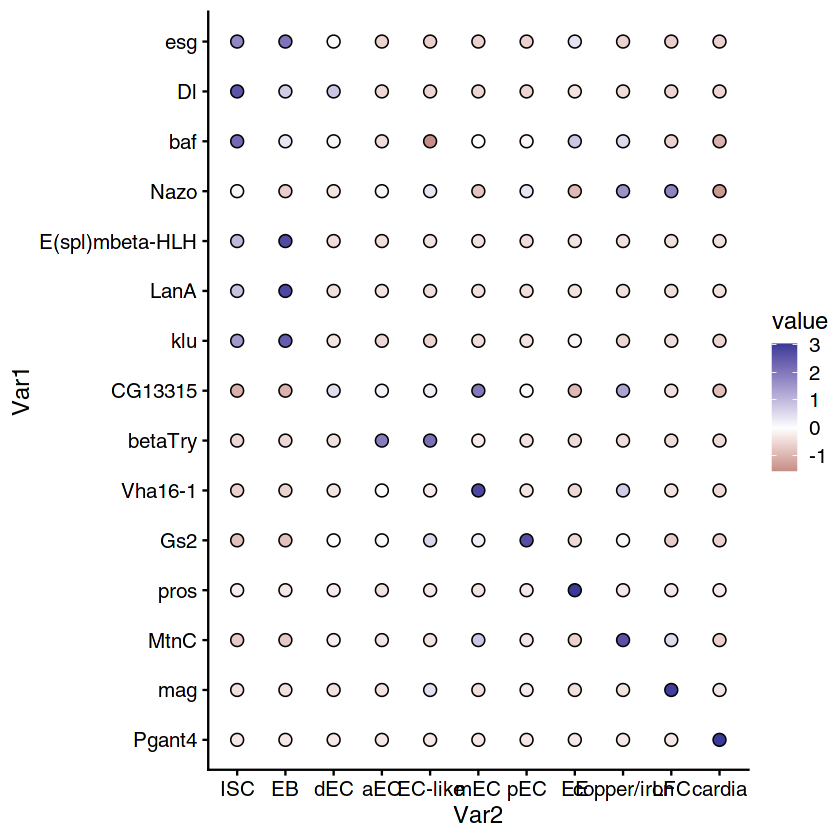

In [8]:
design$z[[1]][genelist, ] %>%
  melt() %>%
  ggplot(aes(Var2, Var1, fill = value)) +
  geom_point(pch = 21, size = 3) +
  scale_y_discrete(limits = rev) +
  scale_fill_gradient2() +
  theme_cowplot()